<a href="https://colab.research.google.com/github/Zukui/CHE358_python/blob/master/03b_nonlinear_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import matplotlib.pyplot as plt 

# nonlinear regression example

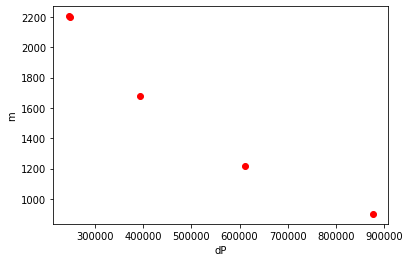

In [0]:
dP = np.array([245182, 877284, 394215, 611533, 248648])
m = np.array([2204.5, 901.1,  1675.9,  1218.0,  2202.7])
n = len(dP)
dP = dP.reshape(n,1)
m = m.reshape(n,1)
plt.plot(dP, m, 'ro')   # scatter plot showing actual data
plt.xlabel('dP')
plt.ylabel('m')
plt.show()

## general initial guess using linear regression based on transformed model

In [0]:
Y = 1./m
X = np.concatenate((np.ones((n,1)), dP),axis=1)
print(X)
print(Y)

[[1.00000e+00 2.45182e+05]
 [1.00000e+00 8.77284e+05]
 [1.00000e+00 3.94215e+05]
 [1.00000e+00 6.11533e+05]
 [1.00000e+00 2.48648e+05]]
[[0.00045362]
 [0.00110975]
 [0.00059669]
 [0.00082102]
 [0.00045399]]


In [0]:
C = np.linalg.inv(X.T@X)
initial_guess_theta = C@X.T@Y
print(initial_guess_theta)

[[1.93695402e-04]
 [1.03775314e-09]]


### convert to original parameter

In [0]:
rho = 1000
g = 9.81;
W0 = 1/(initial_guess_theta[1]*rho)
h0 = initial_guess_theta[0]/(initial_guess_theta[1]*rho*g)
print("initial guess using transformation and linear regression:\n w0=", W0, "h0=", h0, "\n")


initial guess using transformation and linear regression:
 w0= [963620.31101042] h0= [19.02638369] 



## now, start the nonlinear least square algorithm

In [0]:
Y= m.reshape(n,1)

theta = np.array([W0, h0]).reshape(2,1)
flag = 1
i = 1
while flag:
    print("============== iteration ",i,"=============")
    print("theta=", theta[:,-1])
    F = theta[0,-1]/(dP/rho + g*theta[1,-1])
    print("Function value F=",F)
    Z = Y - F
    D = np.concatenate((1/(dP/rho + g*theta[1,-1]),  -theta[0,-1]*g/(dP/rho + g*theta[1,-1])**2), axis=1)
    print("Jacobian matrix D=",D)
    
    dtheta = (np.linalg.inv(D.T@D))@D.T@Z
    print("norm of dtheta", np.linalg.norm(dtheta))

    theta = np.concatenate((theta, theta+dtheta),axis=1)
    
    if np.linalg.norm(dtheta) < 0.001: 
        flag = 0
    i = i+1

hat_theta = theta[:,-1] # final estimator
print("final estimator: ", hat_theta)

============== iteration  1 =============
theta= [9.63620311e+05 1.90263837e+01]
Function value F= [[2231.47644286]
 [ 905.7153697 ]
 [1658.94357891]
 [1207.26917359]
 [2213.70857293]]
Jacobian matrix D= [[ 2.31572168e-03 -5.06929628e+01]
 [ 9.39908966e-04 -8.35115486e+00]
 [ 1.72157390e-03 -2.80173008e+01]
 [ 1.25284737e-03 -1.48378605e+01]
 [ 2.29728301e-03 -4.98889032e+01]]
norm of dtheta 22921.301430275555
============== iteration  2 =============
theta= [9.86541612e+05 2.03877973e+01]
Function value F= [[2216.01974313]
 [ 915.76379298]
 [1660.23154367]
 [1215.64544495]
 [2198.90019517]]
Jacobian matrix D= [[ 2.24625066e-03 -4.88315882e+01]
 [ 9.28256631e-04 -8.33912600e+00]
 [ 1.68288040e-03 -2.74088567e+01]
 [ 1.23222926e-03 -1.46949277e+01]
 [ 2.22889756e-03 -4.80800194e+01]]
norm of dtheta 249.68688343990917
============== iteration  3 =============
theta= [9.86791299e+05 2.04070157e+01]
Function value F= [[2215.6422979 ]
 [ 915.83528942]
 [1660.12501658]
 [1215.67069774]
 [219

## =========================================

## Confidence interval

In [0]:
p = 2
# use the linear approximation model around the estimator 
F_final = hat_theta[0]/(dP/rho + g*hat_theta[1])
Z_final = Y - F_final
D_final = np.concatenate((1/(dP/rho + g*hat_theta[1]),    -hat_theta[0]*g/(dP/rho + g*hat_theta[1])**2), axis=1)
C = np.linalg.inv(D_final.T@D_final)
dtheta = C@D_final.T@Z_final
Z_pred = D_final@dtheta
epsilon = Z_final - Z_pred
sigma2 = epsilon.T@epsilon/(n-p);

from scipy.stats import t as t_dist
t_alpha = t_dist.ppf(1-0.05/2,n-p)

# CI on W and h
print("confidence interval for W: ", hat_theta[0] - t_alpha*np.sqrt(C[0,0]*sigma2),  hat_theta[0] + t_alpha*np.sqrt(C[0,0]*sigma2))
print("confidence interval for h: ", hat_theta[1] - t_alpha*np.sqrt(C[1,1]*sigma2),  hat_theta[1] + t_alpha*np.sqrt(C[1,1]*sigma2))

# CI for mean response at a given point
x0 = 0.5e6  
mu_m = hat_theta[0]/(x0/rho + g*hat_theta[1])
D_x0 = np.array([1/(x0/rho + g*hat_theta[1]),    -hat_theta[0]*g/(x0/rho + g*hat_theta[1])**2]).reshape(1, p)
print("confidence interval for mean response at x0: ", mu_m - t_alpha*np.sqrt(D_x0@C@D_x0.T@sigma2),      mu_m + t_alpha*np.sqrt(D_x0@C@D_x0.T@sigma2)) 

# CI for prediction at a given point
y0 = hat_theta[0]/(x0/rho + g*hat_theta[1])
print("confidence interval for predition at x0: ", y0 - t_alpha*np.sqrt((1+D_x0@C@D_x0.T)@sigma2),    y0 + t_alpha*np.sqrt((1+D_x0@C@D_x0.T)@sigma2))

confidence interval for W:  [[931374.44981685]] [[1042201.64467023]]
confidence interval for h:  [[17.55062271]] [[23.26307097]]
confidence interval for mean response at x0:  [[1382.53141665]] [[1436.09324764]]
confidence interval for predition at x0:  [[1356.52569155]] [[1462.09897274]]


## prediction interval for all data points

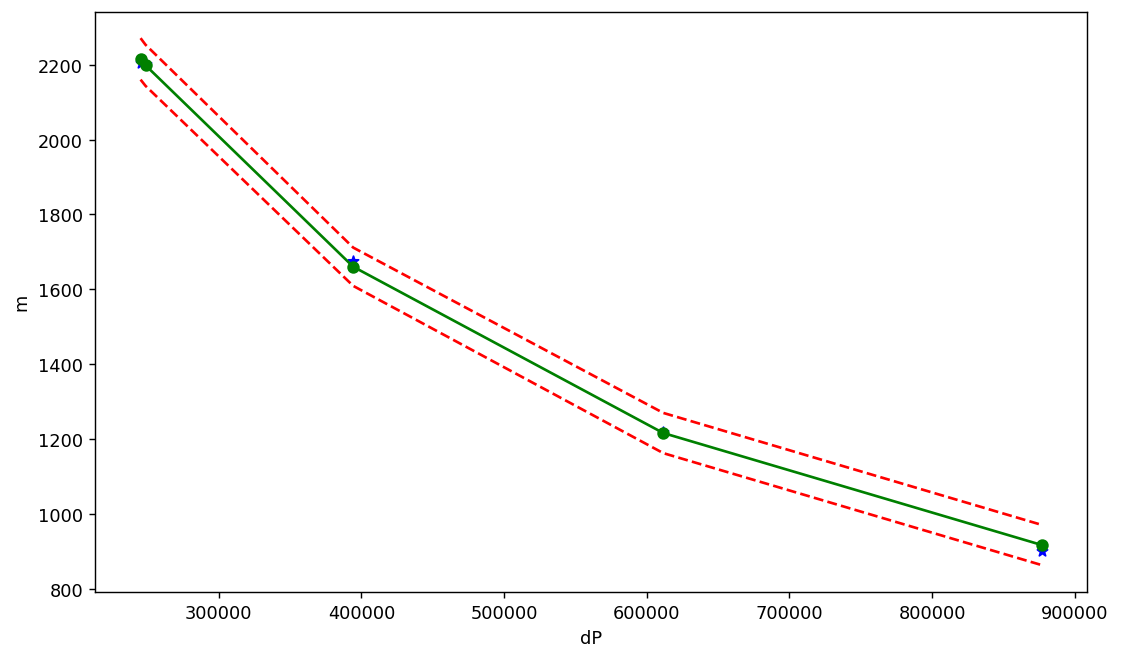

In [0]:
# confidence interval on the mean response and predictions at all given x points
hat_Y0 = hat_theta[0]/(dP/rho + g*hat_theta[1])
CI_Y0_low = np.zeros((n,1))
CI_Y0_high = np.zeros((n,1))
for i in range(n):
    x0 = dP[i]  
    D_x0 = np.array([1/(x0/rho + g*hat_theta[1]),    -hat_theta[0]*g/(x0/rho + g*hat_theta[1])**2]).reshape(1, p)
    CI_Y0_low[i] =  hat_Y0[i] - t_alpha*np.sqrt((1+D_x0@C@D_x0.T)@sigma2)
    CI_Y0_high[i] = hat_Y0[i] + t_alpha*np.sqrt((1+D_x0@C@D_x0.T)@sigma2)

#print(Y)
alldata = np.concatenate((dP, m, hat_Y0, CI_Y0_low, CI_Y0_high),axis=1)
sortdata = alldata[np.argsort(alldata[:, 0])]

#print(sortdata)
plt.figure(dpi=128, figsize=(10, 6))
plt.scatter(sortdata[:,0], sortdata[:,1], c='blue',  marker="*") 
plt.plot(sortdata[:,0], sortdata[:,2], c='green',  marker='o', linestyle='solid') 
plt.plot(sortdata[:,0], sortdata[:,3], c='red',  linestyle='dashed') 
plt.plot(sortdata[:,0], sortdata[:,4], c='red',  linestyle='dashed') 
plt.xlabel('dP')
plt.ylabel('m')
plt.show()